### LSTM Attention

In [1]:
import os
import pathlib
current_dir = pathlib.Path.cwd()
parent_dir = current_dir.parent
preprocessing_output_dir = pathlib.Path('{}/1_preprocessing_all_domain/output_temp'.format(parent_dir))
output_dir = pathlib.Path('{}/output_temp'.format(current_dir))
pathlib.Path.mkdir(output_dir, mode=0o777, exist_ok=True)
print(current_dir)

d:\GIT_CODE\CDM_LSTM\2_lstm_attention_all_domain


In [2]:
with open('{}/0_importsql/abnormal_list.txt'.format(parent_dir), 'r') as f:
    data = f.read()
outcome_name_list = data.splitlines()
outcome_name_list=['abnormal_hepatotoxicity', 'abnormal_nephrotoxicity']

In [3]:
def split_x_y_data(df, OBP) :
    import numpy as np
    import pandas as pd

    y_data = df['label'].T.reset_index(drop=True) #df['label'].T.drop_duplicates().T.reset_index(drop=True)
    y_data = np.array(y_data)
    y_data = y_data[0:len(y_data):OBP].reshape(-1, 1).astype(int)
    #print(len(y_data), file=_logfile_)

    x_df = df.drop('label', axis=1)

    # 2-d data to 3-d data
    timestamp = OBP 
    x_data = np.array(x_df)
    x_data = x_data.reshape(-1, timestamp, x_data.shape[1]) # -1(sample), timestamp, column
    #x_data.shape, y_data.shape

    # get Column data
    new_col = x_df.columns
    print(x_data.shape, y_data.shape, len(new_col))
    return x_data, y_data, new_col

# Model Load

In [4]:
# for linux
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

  0%|          | 0/2 [00:00<?, ?it/s]

(202, 7, 25) (202, 1) 25
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 25)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 7, 20)        3680        input_1[0][0]                    
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 20)           0           lstm[0][0]                       
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 7, 20)        400         lstm[0][0]                       
_____________________________________________________________________

 50%|█████     | 1/2 [00:52<00:52, 52.47s/it]

[0.7560975609756098, 0.8536585365853658, 0.625, 0.85, 0.65]
except: abnormal_hepatotoxicity
(198, 7, 28) (198, 1) 28
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 28)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 7, 20)        3920        input_1[0][0]                    
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 20)           0           lstm[0][0]                       
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 7, 20)        400         lstm[0][0] 

100%|██████████| 2/2 [01:24<00:00, 42.15s/it]

[0.45, 0.55, 0.675, 0.6923076923076923, 0.6666666666666666]
except: abnormal_nephrotoxicity
['abnormal_hepatotoxicity', 'abnormal_nephrotoxicity']


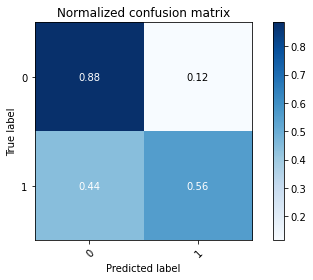

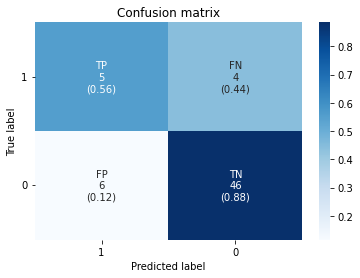

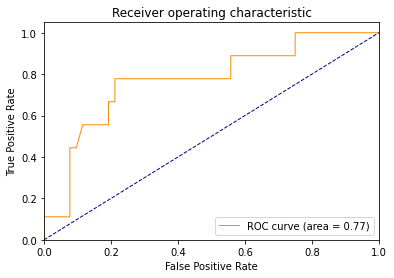

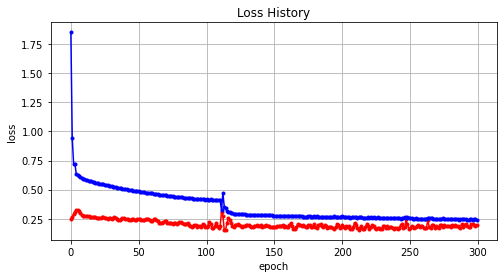

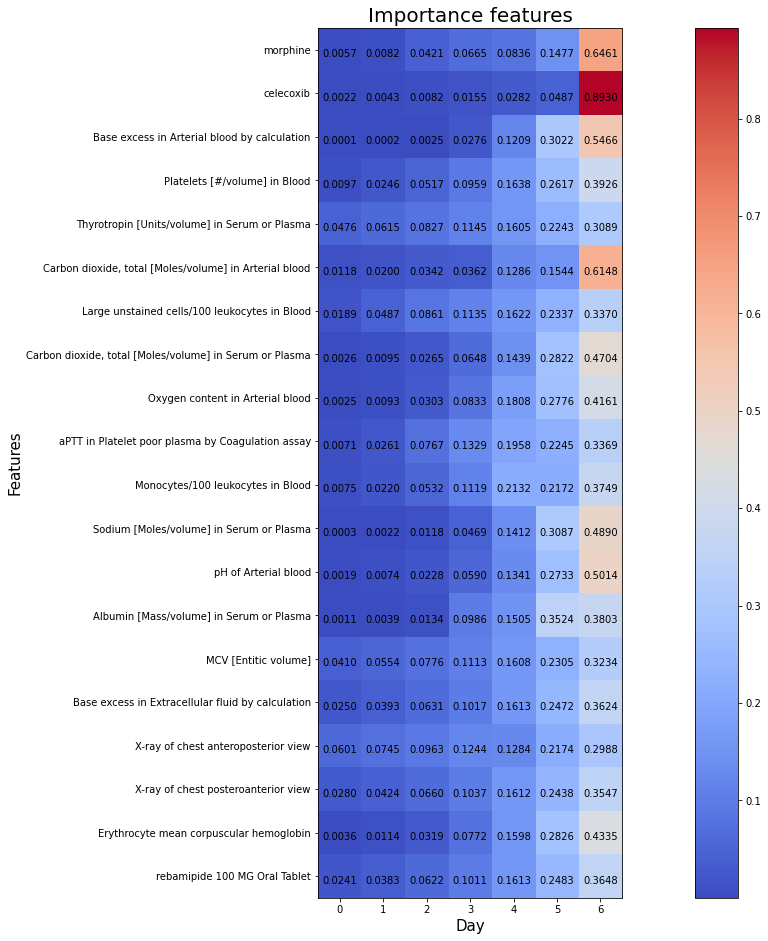

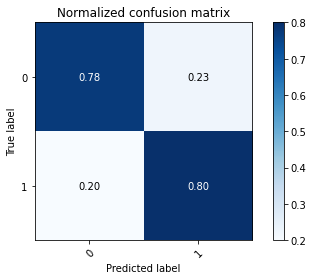

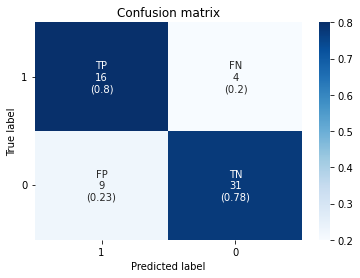

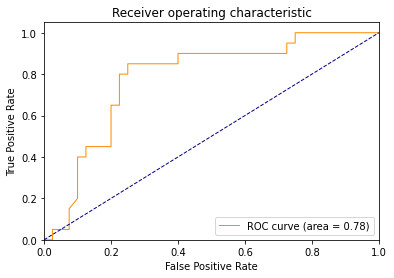

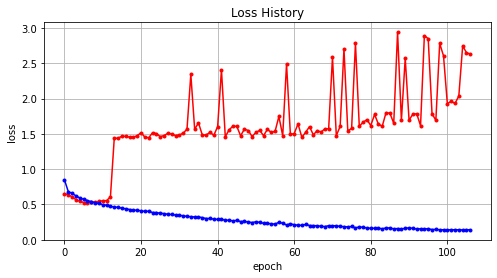

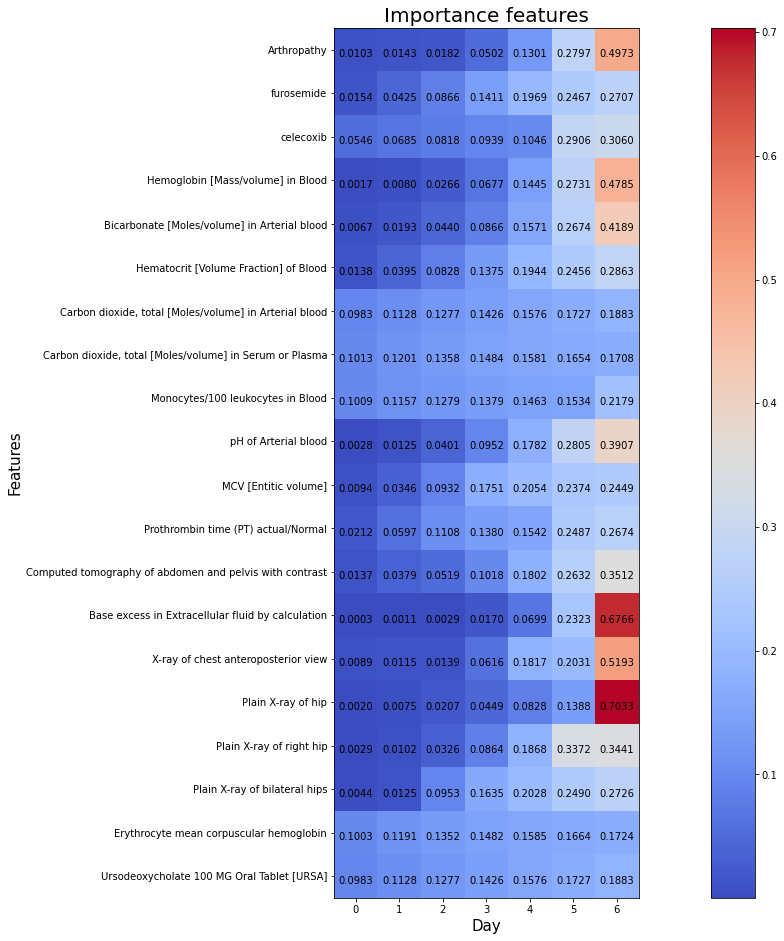

In [12]:
import os
import pickle
from tqdm import tqdm
from Auto_lstm_attention import *
c = Auto_lstm_attention()
error=[]

for outcome_name in tqdm(outcome_name_list):
    #try:
        # 결과물 저장할 폴더 생성
        output_domain_path = pathlib.Path('{}/{}'.format(output_dir, outcome_name))
        pathlib.Path.mkdir(output_domain_path, mode=0o777, parents=True, exist_ok=True)
                
        concat_df = pd.read_csv('{}/{}.txt'.format(preprocessing_output_dir, outcome_name), index_col=False)
        
        # ##### Case 1 : Split by subject_id #####
        # id_data = concat_df[['subject_id', 'label']].drop_duplicates().reset_index(drop=True)
        # x_id_data = np.array(id_data['subject_id'])
        # y_id_data = np.array(id_data['label'])
        
        # x_id_train, x_id_test, y_id_train, y_id_test = train_test_split(x_id_data, y_id_data, test_size=0.3, random_state=1, stratify=y_id_data) 
        
        # train_df = concat_df[concat_df['subject_id'].isin(x_id_train)].reset_index(drop=True)
        # test_df = concat_df[concat_df['subject_id'].isin(x_id_test)].reset_index(drop=True)
        
        # train_df.to_csv('{}/{}_train.txt'.format(output_domain_path, outcome_name), index=False)
        # test_df.to_csv('{}/{}_test.txt'.format(output_domain_path, outcome_name), index=False)
        
        # concat_df = concat_df.drop(['subject_id', 'unique_id', 'cohort_start_date', 'concept_date', 'first_abnormal_date'], axis=1)
        # train_df = train_df.drop(['subject_id', 'unique_id', 'cohort_start_date', 'concept_date', 'first_abnormal_date'], axis=1)
        # test_df = test_df.drop(['subject_id', 'unique_id', 'cohort_start_date', 'concept_date', 'first_abnormal_date'], axis=1)
        
        # x_data, y_data, new_col = split_x_y_data(concat_df, OBP=28)
        # x_train, y_train, new_col = split_x_y_data(train_df, OBP=28)
        # x_test, y_test, new_col = split_x_y_data(test_df, OBP=28)
        
        #### Case 2 : Split ignore subject_id #####
        concat_df = concat_df.drop(['subject_id', 'unique_id', 'cohort_start_date', 'concept_date', 'first_abnormal_date'], axis=1)
    
        x_data, y_data, new_col = split_x_y_data(concat_df, OBP=7)
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1, stratify=y_data) 
        
        c = Auto_lstm_attention()
        model = c.LSTM_attention_building(x_train, x_test, y_train, y_test)
        weights = c.class_balance_weight(output_domain_path, outcome_name, y_train)
        h, y_hat = c.early_stopping_prediction()
        c.classification_report(output_domain_path, outcome_name)
        c.model_performance_evaluation(output_dir, outcome_name)
        c.confusion_matrix_figure(output_domain_path, outcome_name)
        c.confusion_matrix_figure2(output_domain_path, outcome_name)
        AUC, ACC = c.ROC_AUC(output_domain_path, outcome_name)
        c.loss(output_domain_path, outcome_name)
        
        if_ = c.attention_heatmap(new_col, output_domain_path, outcome_name)
        accuracy = c.k_fold_cross_validation(x_data, y_data, output_domain_path, outcome_name)
        
        # (['AUC','ACC','import_f', 'k_fold'])
        model.save('{}/{}.h5'.format(output_domain_path, outcome_name))
        
    
        out = open('{}/output.txt'.format(output_dir),'a')
        
        out.write(str(outcome_name))
        out.write('///' )
        out.write(str(AUC ))
        out.write('///' )
        out.write(str(ACC ))
        out.write('///' )
        out.write(str(str(if_) ))
        out.write('///' )
        out.write(str(accuracy))
        out.write('\n')
        
        out.close()

    #except:
        print('except:', outcome_name)
        error.append(outcome_name)
    
print(error)